In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import os, sys, getpass
user = getpass.getuser()
sys.path.append(f'/home/{user}/codes/hpe_library/')
from lib_import import *
from my_utils import *
os.chdir('/home/hrai/codes/MotionBERT')

In [2]:
def get_subject_list_from_source_list(pkl_data, dataset_name, data_type):
    if len(pkl_data[data_type]['source']) <= 243: subject_list = []
    else:
        subject_list = []
        for source in pkl_data[data_type]['source']:
            if dataset_name == 'fit3d': subject = source.split('_')[1]
            else: subject = source.split('_')[0]
            subject_list.append(subject)
        subject_list = list(set(subject_list))
    return subject_list

In [3]:
pkl_root = '/home/hrai/codes/MotionBERT/data/motion3d'
pkl_list = glob(pkl_root + '/*.pkl')
pkl_list

['/home/hrai/codes/MotionBERT/data/motion3d/fit3d_gt_canonical_3d_same_z_all_test.pkl',
 '/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_canonical_3d_same_dist_s15678_tr_54138969_ts_others.pkl',
 '/home/hrai/codes/MotionBERT/data/motion3d/3dhp_gt_test_canonical_3d_from_same_z_TS1_6.pkl',
 '/home/hrai/codes/MotionBERT/data/motion3d/fit3d_gt_canonical_3d_same_z_tr_s03.pkl',
 '/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_canonical_3d_same_z_tr_s1_ts_s5678.pkl',
 '/home/hrai/codes/MotionBERT/data/motion3d/3dhp_gt_test_TS1_4.pkl',
 '/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_canonical_3d_same_dist_tr_s1_ts_s5678.pkl',
 '/home/hrai/codes/MotionBERT/data/motion3d/3dhp_gt_test_canonical_3d_from_fixed_dist_5_TS1_6.pkl',
 '/home/hrai/codes/MotionBERT/data/motion3d/fit3d_all_train_except_target_action.pkl',
 '/home/hrai/codes/MotionBERT/data/motion3d/h36m_sh_conf_cam_source_final.pkl',
 '/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_canonical_3d_same_z.pkl',
 '/home/hrai/codes/

In [9]:
filtered_pkl_list = []
blacklist_pkl_list = ['h36m_gt_dict.pkl', 'h36m_gt_s15678_tr_54138969_ts_others.pkl', 'h36m_gt_canonical_3d_same_dist_s15678_tr_54138969_ts_others.pkl', 'h36m_sh_conf_cam_source_final.pkl']
whitelist_pkl_list = ['h36m_gt.pkl', 'h36m_gt_canonical_3d_same_z.pkl', 'h36m_gt_canonical_3d_fixed_dist_5.pkl']
blacklist_data_type = ['world_3d_from_canonical_3d', 'confidence', 'joint3d_image_from_canonical_3d', 'frame', 'camera_name', 'action', 'source', 'cam_param', 'joints_2.5d_image', 'joints_2.5d_image_from_canonical_3d', '2.5d_factor_from_canonical_3d']
whitelist_data_type = ['joint_2d', 'joint_2d_from_canonical_3d', 'cam_3d_from_canonical_3d', 'world_3d', 'cam_3d']
train_subject = ['S1', 'S5', 'S8', 'S6', 'S7'] 
test_subject = ['S9', 'S11']


error_list = {}
for item in pkl_list:
    pkl_name = os.path.basename(item)
    if pkl_name not in whitelist_pkl_list: continue
    error_list[pkl_name] = {}
    dataset_name = pkl_name.split('_')[0]
    if dataset_name != 'h36m': continue
    filtered_pkl_list.append(item)
    if 'canonical_3d_same_z' in pkl_name: canonical_type = 'same_z'
    elif 'canonical_3d_fixed_dist_5' in pkl_name: canonical_type = 'fixed_dist_5'
    elif 'canonical_3d_same_dist' in pkl_name: canonical_type = 'same_dist'
    else: canonical_type = None
    print(dataset_name, canonical_type)
    pkl_data = readpkl(item)
    # train_subject = get_subject_list_from_source_list(pkl_data, dataset_name, 'train')
    # test_subject = get_subject_list_from_source_list(pkl_data, dataset_name, 'test')
    # print(train_subject, test_subject)
    
    source_location = {}
    for source in tqdm(list(set(pkl_data['test']['source']))):
        source_location[source] = np.where(pkl_data['test']['source'] == source)[0]

    for item in list(pkl_data['test'].keys()):
        if item not in whitelist_data_type: continue
        error_list[pkl_name][item] = []
        print(item, len(pkl_data['test'][item]))
        if item == 'joint_2d':                     data_type = 'img_2d'
        elif item == 'joint_2d_from_canonical_3d': data_type = 'img_2d_canonical'
        elif item == 'cam_3d_from_canonical_3d':   data_type = 'cam_3d_canonical'
        elif item == 'joint3d_image':              data_type = 'img_3d'
        elif item == '2.5d_factor':                data_type = 'scale_factor'
        else:                                      data_type = item
            
        data_tar = pkl_data['test'][item].copy()
        data_src = load_data(dataset_name=dataset_name, data_type=data_type, canonical_type=canonical_type, overwrite=False)
        error_cnt = 0
        for source in tqdm(source_location.keys()):
            location = source_location[source]
            subject, cam_id, action = source.split('_')
            _data_tar = pkl_data['test'][item][location].copy()
            if data_type == 'world_3d': _data_src = data_src[subject][action]
            elif 'img_2d' in data_type: _data_src = data_src[subject][action][cam_id][...,:2]
            else: _data_src = data_src[subject][action][cam_id]
            if item == 'joint3d_image': atol = 1
            else: atol = 1e-07
            if not np.allclose(_data_tar, _data_src, atol=1e-07): 
                error_cnt += 1
                error_list[pkl_name][item].append(f'{item} {error_cnt} {(_data_tar - _data_src).max()}, {(_data_tar - _data_src).argmax()}')

h36m same_z


100%|██████████| 236/236 [00:00<00:00, 394.84it/s]


joint_2d 543344
==> Loading H36M data img_2d same_z...


100%|██████████| 236/236 [00:00<00:00, 945.30it/s]


joint_2d_from_canonical_3d 543344
==> Loading H36M data img_2d_canonical same_z...


100%|██████████| 236/236 [00:00<00:00, 959.50it/s]


world_3d 543344
==> Loading H36M data world_3d same_z...


100%|██████████| 236/236 [00:00<00:00, 2965.98it/s]


cam_3d 543344
==> Loading H36M data cam_3d same_z...


100%|██████████| 236/236 [00:00<00:00, 2747.50it/s]


cam_3d_from_canonical_3d 543344
==> Loading H36M data cam_3d_canonical same_z...


100%|██████████| 236/236 [00:00<00:00, 2689.66it/s]


h36m None


100%|██████████| 236/236 [00:00<00:00, 393.86it/s]


joint_2d 543344
==> Loading H36M data img_2d None...


100%|██████████| 236/236 [00:00<00:00, 963.65it/s]


world_3d 543344
==> Loading H36M data world_3d None...


100%|██████████| 236/236 [00:00<00:00, 2114.50it/s]


cam_3d 543344
==> Loading H36M data cam_3d None...


100%|██████████| 236/236 [00:00<00:00, 2829.53it/s]


h36m fixed_dist_5


100%|██████████| 236/236 [00:00<00:00, 387.51it/s]


joint_2d 543344
==> Loading H36M data img_2d fixed_dist_5...


100%|██████████| 236/236 [00:00<00:00, 949.02it/s]


joint_2d_from_canonical_3d 543344
==> Loading H36M data img_2d_canonical fixed_dist_5...


100%|██████████| 236/236 [00:00<00:00, 937.14it/s]


cam_3d 543344
==> Loading H36M data cam_3d fixed_dist_5...


100%|██████████| 236/236 [00:00<00:00, 2616.02it/s]


cam_3d_from_canonical_3d 543344
==> Loading H36M data cam_3d_canonical fixed_dist_5...


100%|██████████| 236/236 [00:00<00:00, 2254.75it/s]


In [10]:
for key in error_list.keys():
    print(key)
    for data_type in error_list[key].keys():
        print(data_type, len(error_list[key][data_type]))

h36m_gt_canonical_3d_same_z.pkl
joint_2d 0
joint_2d_from_canonical_3d 0
world_3d 0
cam_3d 0
cam_3d_from_canonical_3d 0
h36m_gt.pkl
joint_2d 0
world_3d 0
cam_3d 0
h36m_gt_canonical_3d_fixed_dist_5.pkl
joint_2d 0
joint_2d_from_canonical_3d 0
cam_3d 0
cam_3d_from_canonical_3d 236


### Compare cam_3d_from_canonical_3d_fixed_dist_5

In [14]:
pkl_data = readpkl( '/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_canonical_3d_fixed_dist_5.pkl')

In [15]:
cam_3d_canonical_h36m = load_data(dataset_name='h36m', data_type='cam_3d_canonical', canonical_type='fixed_dist_5', overwrite=False)

==> Loading H36M data cam_3d_canonical fixed_dist_5...


In [16]:
source = pkl_data['test']['source'][0]
subject, cam_id, action = source.split('_')
cam_3d_from_canonical_3d_tar = pkl_data['test']['cam_3d_from_canonical_3d'][0]
cam_3d_from_canonical_3d_src = cam_3d_canonical_h36m[subject][action][cam_id][0]

In [17]:
cam_3d_from_canonical_3d_src - cam_3d_from_canonical_3d_tar*1000

array([[-2.22044605e-16,  0.00000000e+00,  8.88178420e-16],
       [-1.38777878e-16, -2.22044605e-16,  8.88178420e-16],
       [-1.38777878e-16, -2.22044605e-16,  8.88178420e-16],
       [-2.22044605e-16, -3.33066907e-16,  8.88178420e-16],
       [-4.16333634e-17, -2.22044605e-16,  8.88178420e-16],
       [ 9.71445147e-17, -4.44089210e-16,  8.88178420e-16],
       [-2.37011730e-10,  3.58440522e-09,  9.86740467e-10],
       [ 8.32667268e-17, -3.60822483e-16,  8.88178420e-16],
       [ 1.38777878e-17, -2.22044605e-16,  8.88178420e-16],
       [-4.16333634e-17, -4.44089210e-16,  1.77635684e-15],
       [-1.11022302e-16, -4.44089210e-16,  1.77635684e-15],
       [ 2.22044605e-16, -4.44089210e-16,  8.88178420e-16],
       [ 1.36414278e-08, -7.36211425e-10,  5.95097127e-09],
       [ 1.36414272e-08, -7.36211536e-10,  5.95097127e-09],
       [-8.32667268e-17, -2.22044605e-16,  8.88178420e-16],
       [ 1.36414275e-08, -7.36211314e-10,  5.95097127e-09],
       [ 1.36414275e-08, -7.36211203e-10

In [19]:
cam_3d_from_canonical_3d_tar*1000

array([[ 2.22044605e-16,  0.00000000e+00,  5.00000000e+00],
       [-1.14822700e-01, -1.00883456e-02,  4.95408178e+00],
       [-1.75739493e-01,  4.34277366e-01,  5.10171154e+00],
       [-2.62543082e-01,  8.49633830e-01,  5.30059061e+00],
       [ 1.14822996e-01,  1.00883911e-02,  5.04591836e+00],
       [ 9.49098671e-02,  4.56449337e-01,  5.19866864e+00],
       [ 5.40998990e-02,  8.71786481e-01,  5.41183045e+00],
       [ 2.13018368e-02, -2.45163514e-01,  4.92842082e+00],
       [ 3.49112291e-02, -4.90075550e-01,  4.87830568e+00],
       [ 5.70677237e-02, -5.82878766e-01,  4.80461929e+00],
       [ 4.42193192e-02, -6.94898080e-01,  4.82722266e+00],
       [ 1.93368032e-01, -4.99214627e-01,  4.96997861e+00],
       [ 4.58731849e-01, -4.67511548e-01,  5.09797373e+00],
       [ 7.04112560e-01, -4.50568751e-01,  5.13683072e+00],
       [-1.42880809e-01, -4.80376581e-01,  4.83480765e+00],
       [-4.24971698e-01, -4.40937372e-01,  4.75310656e+00],
       [-6.34526430e-01, -4.23155928e-01

In [33]:
cam_3d_from_canonical_3d_tar*1000

array([[ 2.22044605e-16,  0.00000000e+00,  5.00000000e+00],
       [-1.14822700e-01, -1.00883456e-02,  4.95408178e+00],
       [-1.75739493e-01,  4.34277366e-01,  5.10171154e+00],
       [-2.62543082e-01,  8.49633830e-01,  5.30059061e+00],
       [ 1.14822996e-01,  1.00883911e-02,  5.04591836e+00],
       [ 9.49098671e-02,  4.56449337e-01,  5.19866864e+00],
       [ 5.40998990e-02,  8.71786481e-01,  5.41183045e+00],
       [ 2.13018368e-02, -2.45163514e-01,  4.92842082e+00],
       [ 3.49112291e-02, -4.90075550e-01,  4.87830568e+00],
       [ 5.70677237e-02, -5.82878766e-01,  4.80461929e+00],
       [ 4.42193192e-02, -6.94898080e-01,  4.82722266e+00],
       [ 1.93368032e-01, -4.99214627e-01,  4.96997861e+00],
       [ 4.58731849e-01, -4.67511548e-01,  5.09797373e+00],
       [ 7.04112560e-01, -4.50568751e-01,  5.13683072e+00],
       [-1.42880809e-01, -4.80376581e-01,  4.83480765e+00],
       [-4.24971698e-01, -4.40937372e-01,  4.75310656e+00],
       [-6.34526430e-01, -4.23155928e-01

### Compare img_3d

In [2]:
pkl_data = readpkl( '/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt.pkl')

In [3]:
pkl_data['train']['confidence'].shape

(1559752, 17)

In [8]:
cam_3d_h36m = load_data(dataset_name='h36m', data_type='cam_3d', overwrite=False)
img_3d_h36m = load_data(dataset_name='h36m', data_type='img_3d', overwrite=False)
#scale_factor_h36m = load_data(dataset_name='h36m', data_type='scale_factor', overwrite=True)

==> Loading H36M data cam_3d ...
==> Loading H36M data img_3d ...


In [9]:
source = pkl_data['test']['source'][0]
subject, cam_id, action = source.split('_')
cam_3d_tar = pkl_data['test']['cam_3d'][0]
img_3d_tar = pkl_data['test']['joint3d_image'][0]
cam_3d_src = cam_3d_h36m[subject][action][cam_id][0]
img_3d_src = img_3d_h36m[subject][action][cam_id][0]
cam_3d_tar_hat = cam_3d_tar.copy() - cam_3d_tar[0]
cam_3d_src_hat = cam_3d_src.copy() - cam_3d_src[0]
img_3d_tar_hat = img_3d_tar.copy() - img_3d_tar[0]
img_3d_src_hat = img_3d_src.copy() - img_3d_src[0]
#scale_factor_tar = pkl_data['test']['2.5d_factor'][0]
#scale_factor_src = 1/scale_factor_h36m[subject][action][cam_id][1]
img_3d_tar.shape, img_3d_src.shape

((17, 3), (17, 3))

In [111]:
scale_factor_tar, scale_factor_src

(3.6946566104888916, 3.7103521073730272)

In [10]:
(img_3d_tar_hat - img_3d_src_hat)

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -1.13686838e-13, -2.29361534e-02],
       [ 0.00000000e+00, -1.13686838e-13,  5.08049125e-02],
       [ 0.00000000e+00,  0.00000000e+00,  1.50145008e-01],
       [ 0.00000000e+00, -5.68434189e-14,  2.29362186e-02],
       [ 0.00000000e+00, -5.68434189e-14,  9.92349873e-02],
       [-5.68434189e-14, -1.13686838e-13,  2.05709309e-01],
       [ 0.00000000e+00, -1.13686838e-13, -3.57537982e-02],
       [ 5.68434189e-14, -2.84217094e-14, -6.07863136e-02],
       [-5.68434189e-14,  0.00000000e+00, -9.75926624e-02],
       [ 0.00000000e+00, -5.68434189e-14, -8.63022808e-02],
       [ 0.00000000e+00, -5.68434189e-14, -1.49956859e-02],
       [ 0.00000000e+00, -5.68434189e-14,  4.89378836e-02],
       [ 0.00000000e+00, -8.52651283e-14,  6.83469496e-02],
       [ 0.00000000e+00, -1.70530257e-13, -8.25135808e-02],
       [ 5.68434189e-14, -1.13686838e-13, -1.23323270e-01],
       [-5.68434189e-14, -1.13686838e-13

In [13]:
(img_3d_tar_hat-img_3d_src_hat)/1000

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -1.13686838e-16, -2.29361534e-05],
       [ 0.00000000e+00, -1.13686838e-16,  5.08049125e-05],
       [ 0.00000000e+00,  0.00000000e+00,  1.50145008e-04],
       [ 0.00000000e+00, -5.68434189e-17,  2.29362186e-05],
       [ 0.00000000e+00, -5.68434189e-17,  9.92349873e-05],
       [-5.68434189e-17, -1.13686838e-16,  2.05709309e-04],
       [ 0.00000000e+00, -1.13686838e-16, -3.57537982e-05],
       [ 5.68434189e-17, -2.84217094e-17, -6.07863136e-05],
       [-5.68434189e-17,  0.00000000e+00, -9.75926624e-05],
       [ 0.00000000e+00, -5.68434189e-17, -8.63022808e-05],
       [ 0.00000000e+00, -5.68434189e-17, -1.49956859e-05],
       [ 0.00000000e+00, -5.68434189e-17,  4.89378836e-05],
       [ 0.00000000e+00, -8.52651283e-17,  6.83469496e-05],
       [ 0.00000000e+00, -1.70530257e-16, -8.25135808e-05],
       [ 5.68434189e-17, -1.13686838e-16, -1.23323270e-04],
       [-5.68434189e-17, -1.13686838e-16

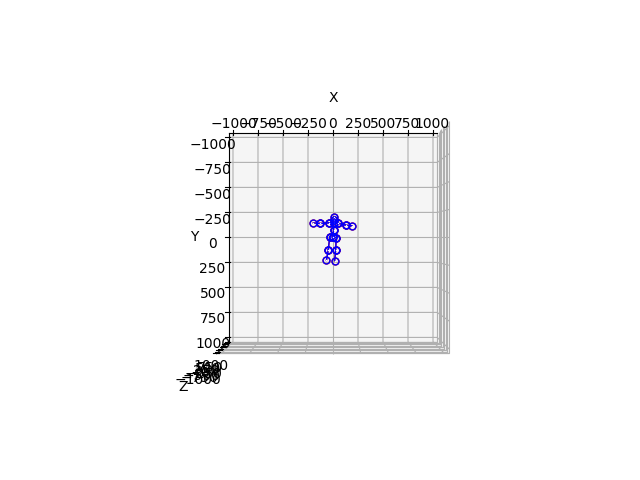

In [11]:
fig = plt.figure(0)
fig.clear()
plot_configs = load_plot_configs(dataset_name)
ax_cam_scaled = axes_3d(fig,
                        xlim=plot_configs['ax_cam_scaled_xlim'], 
                        ylim=plot_configs['ax_cam_scaled_ylim'], 
                        zlim=plot_configs['ax_cam_scaled_zlim'],
                        view=plot_configs['ax_cam_scaled_view'])

#draw_3d_pose(ax_cam_scaled, cam_3d_tar_hat*1000, color='k', markeredgewidth=5)
#draw_3d_pose(ax_cam_scaled, cam_3d_src_hat*1000, color='b', markeredgewidth=5)
draw_3d_pose(ax_cam_scaled, img_3d_tar_hat, color='r', markeredgewidth=5)
draw_3d_pose(ax_cam_scaled, img_3d_src_hat, color='b', markeredgewidth=5)

plt.show()